# H1975_replicates

## Dataprocessing
### Imports

In [1]:
%matplotlib inline
import pandas as pdb
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from dbspro.notebook import *

In [2]:
from datetime import date

def today():
    return date.today().strftime("%y%m%d")
print(today())

220211


### Data loading

In [3]:
# Load metadata
abc_target = pd.read_csv("../data/h1975_replicates.abc_target.csv", names=["abc", "target"]).set_index("abc").to_dict()["target"]
display(abc_target)
targets = list(abc_target.values())
display(targets)
sample_names= pd.read_csv("../data/h1975_replicates.samples.tsv", dtype=str, sep="\t")
samples = sorted(sample_names["Sample"].to_list())
display(samples)
display(sample_names)

{'ABC01': 'EGFR',
 'ABC12': 'Her2',
 'ABC09': 'CD9',
 'ABC03': 'CD3',
 'ABC18': 'PD1',
 'ABC07': 'CD4',
 'ABC22': 'CD8',
 'ABC19': 'PD-L1',
 'ABC13': 'IGF1R-α',
 'ABC14': 'NY-ESO1',
 'ABC16': 'EpCam'}

['EGFR',
 'Her2',
 'CD9',
 'CD3',
 'PD1',
 'CD4',
 'CD8',
 'PD-L1',
 'IGF1R-α',
 'NY-ESO1',
 'EpCam']

['H1975_1', 'H1975_2', 'H1975_3']

,Sample,Reads,FastqPath
0,H1975_1,1967979,/Users/pontus.hojer/analysis/DBS-Pro_Exosomes/...
1,H1975_2,2611402,/Users/pontus.hojer/analysis/DBS-Pro_Exosomes/...
2,H1975_3,2062477,/Users/pontus.hojer/analysis/DBS-Pro_Exosomes/...


In [6]:
# Load data
data_raw = pd.read_csv("../data/h1975_replicates.tsv.gz", sep="\t")

# Rename ABCs to targets
data_raw.replace({"Target": abc_target}, inplace=True)

# Filter out UMIs with only one read count
print("Size before:", len(data_raw))
data_raw = data_raw[data_raw["ReadCount"] > 1]
print("Size after:", len(data_raw))

Size before: 1839593
Size after: 606650


### Overall QC

In [8]:
%matplotlib inline

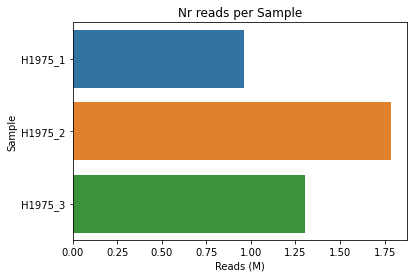

In [9]:
d = data_raw.groupby("Sample", as_index=False).sum()
d["ReadCount"] /= 1_000_000
ax = sns.barplot(data=d, y="Sample", x="ReadCount", order=samples)
_ = ax.set_xlabel("Reads (M)")
_ = ax.set_title("Nr reads per Sample")

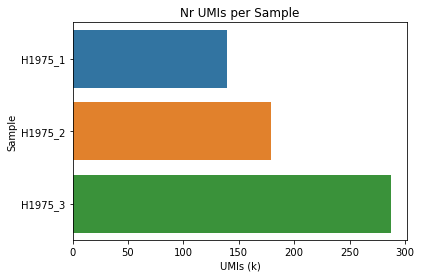

In [10]:
d = data_raw.groupby("Sample", as_index=False).count()
d["UMI"] /= 1_000
ax = sns.barplot(data=d, y="Sample", x="UMI", order=samples)
_ = ax.set_xlabel("UMIs (k)")
_ = ax.set_title("Nr UMIs per Sample")

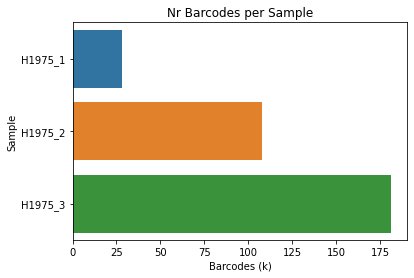

In [11]:
d = data_raw.groupby("Sample").agg({"Barcode":"nunique"})
d["Barcode"] /= 1_000
ax = sns.barplot(data=d, y=d.index, x="Barcode", order=samples)
_ = ax.set_xlabel("Barcodes (k)")
_ = ax.set_title("Nr Barcodes per Sample")

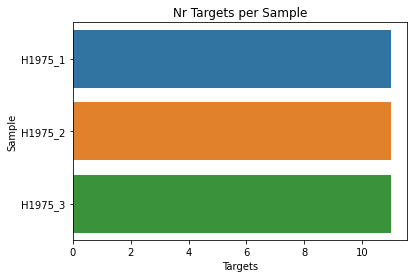

In [12]:
d = data_raw.groupby("Sample").agg({"Target":"nunique"})
ax = sns.barplot(data=d, y=d.index, x="Target", order=samples)
_ = ax.set_xlabel("Targets")
_ = ax.set_title("Nr Targets per Sample")

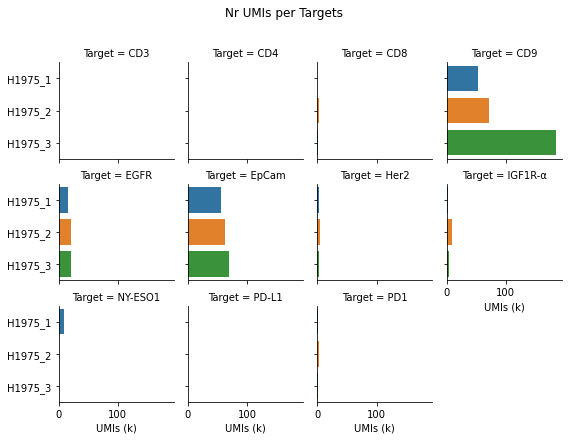

In [15]:
d = data_raw.groupby(["Sample", "Target"], as_index=False).agg({"UMI":"count"})
d["UMI"] /= 1000
g = sns.catplot(data=d, y="Sample", x="UMI",  col="Target", col_wrap=4, kind="bar", height=2)
g.fig.subplots_adjust(top=0.85)
_ = g.fig.suptitle("Nr UMIs per Targets")
_ = g.set_axis_labels("UMIs (k)", "")

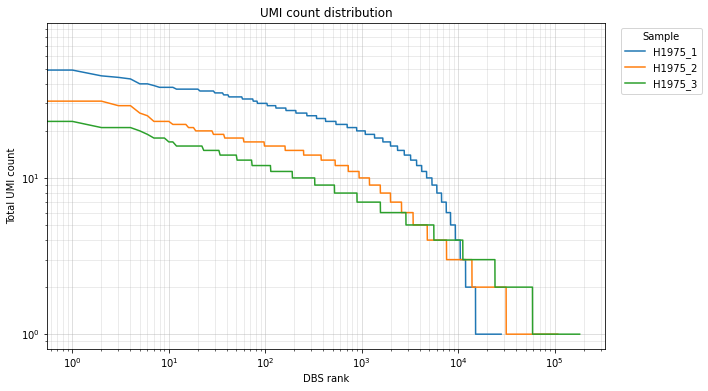

In [16]:
fig, ax = plt.subplots(figsize=(10,6))
ax.set_title("UMI count distribution")
for sample in samples:
    temp = data_raw[data_raw["Sample"] == sample].groupby("Barcode", as_index=False)["UMI"].count().sort_values(by="UMI",ascending=False).reset_index(drop=True)
    try:
        temp.plot(ax=ax, y="UMI", logx=True, logy=True, label=sample)
    except TypeError:
        pass
    
ax.set_xlabel("DBS rank")
ax.set_ylabel("Total UMI count")
ax.grid('on', which='major', axis='y', alpha=0.5 )
ax.grid('on', which='major', axis='x',alpha=0.5)
ax.grid('on', which='minor', axis='y', alpha=0.3)
ax.grid('on', which='minor', axis='x', alpha=0.3)
_ = plt.legend(bbox_to_anchor=(1.02, 1), title="Sample", loc='upper left')

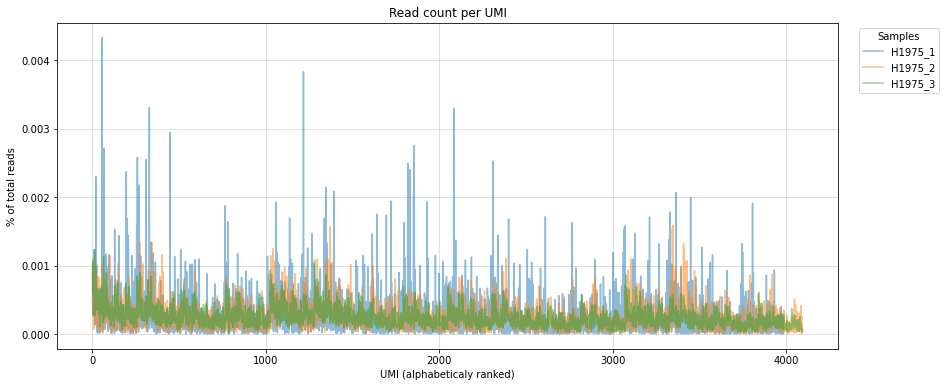

In [17]:
fig, ax = plt.subplots(figsize=(14,6))
ax.set_title("Read count per UMI")
for sample in samples:
    temp = data_raw[data_raw["Sample"] == sample].groupby("UMI", as_index=False)["ReadCount"].sum().sort_values(by="UMI",ascending=False).reset_index(drop=True)
    temp["GC"] = temp["UMI"].apply(lambda x: sum([c in {"G","C"} for c in x])/len(x)) 
    temp["ReadCount"] = temp["ReadCount"]/temp["ReadCount"].sum()
    try:
        temp.plot(ax=ax, y="ReadCount", logx=False, logy=False, label=sample, alpha=0.5)
    except TypeError:
        pass
ax.set_xlabel("UMI (alphabeticaly ranked)")
ax.set_ylabel("% of total reads")
ax.grid('on', which='major', axis='y', alpha=0.5 )
ax.grid('on', which='major', axis='x',alpha=0.5)
ax.grid('on', which='minor', axis='y', alpha=0.3)
ax.grid('on', which='minor', axis='x', alpha=0.3)
_ = plt.legend(bbox_to_anchor=(1.02, 1), title="Samples", loc='upper left')

(-5.0, 200.0)

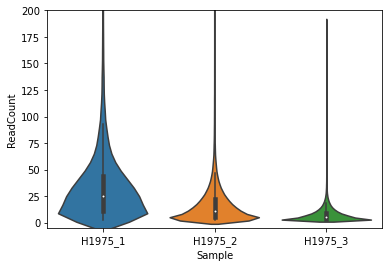

In [18]:
ax = sns.violinplot(data=data_raw.groupby(["Sample","Barcode"], as_index=False)["ReadCount"].sum(), kind="violin", x="Sample", y="ReadCount", bw_adjust=0.1, scale="width")
ax.set_ylim(-5,200)

## Filter and create count matrix

In [20]:
data_count = []
for sample in tqdm(samples):
    print(sample)
    d = data_raw[data_raw["Sample"]==sample]\
            .filter_rc(1)\
            .filter_uc(1)\
            .filter_ratio(2)\
            .filter_target_count(1)\
            .filter_dups(0.5, min_len=2)
    data_count.append(d.to_matrix(qc=True).assign(Sample=sample))
    print("")
data_count = pd.concat(data_count)

  0%|          | 0/3 [00:00<?, ?it/s]

H1975_1
Filtering molecules per readcount gt 1
Barcodes = 27,857 (-0, -0.0%, runtime:0.015884876251220703 s)
Filtering barcodes by total UMI count gt 1
Barcodes = 15,099 (-12,758, -45.8%, runtime:0.043811798095703125 s)
Filtering barcodes by Reads/UMI ratio gt 2
Barcodes = 12,116 (-2,983, -19.76%, runtime:0.054875850677490234 s)
Filtering for targets with UMI count gt 1
Barcodes = 11,439 (-677, -5.59%, runtime:0.041116952896118164 s)
Filter barcodes whose UMI + Target combos have a jaccard index >0.5


Parsing pairs:   0%|          | 0.00/65.4M [00:00<?, ?it/s]

Barcodes = 9,187 (-2,252, -19.69%, runtime:91.3668839931488 s)

H1975_2
Filtering molecules per readcount gt 1
Barcodes = 107,656 (-0, -0.0%, runtime:0.029603958129882812 s)
Filtering barcodes by total UMI count gt 1
Barcodes = 31,356 (-76,300, -70.87%, runtime:0.09093403816223145 s)
Filtering barcodes by Reads/UMI ratio gt 2
Barcodes = 26,302 (-5,054, -16.12%, runtime:0.06912803649902344 s)
Filtering for targets with UMI count gt 1
Barcodes = 17,485 (-8,817, -33.52%, runtime:0.04269599914550781 s)
Filter barcodes whose UMI + Target combos have a jaccard index >0.5


Parsing pairs:   0%|          | 0.00/153M [00:00<?, ?it/s]

Barcodes = 10,058 (-7,427, -42.48%, runtime:134.2743842601776 s)

H1975_3
Filtering molecules per readcount gt 1
Barcodes = 181,529 (-0, -0.0%, runtime:0.047760009765625 s)
Filtering barcodes by total UMI count gt 1
Barcodes = 58,816 (-122,713, -67.6%, runtime:0.16390776634216309 s)
Filtering barcodes by Reads/UMI ratio gt 2
Barcodes = 48,622 (-10,194, -17.33%, runtime:0.1538701057434082 s)
Filtering for targets with UMI count gt 1
Barcodes = 39,646 (-8,976, -18.46%, runtime:0.08901405334472656 s)
Filter barcodes whose UMI + Target combos have a jaccard index >0.5


Parsing pairs:   0%|          | 0.00/786M [00:00<?, ?it/s]

Barcodes = 30,351 (-9,295, -23.44%, runtime:784.7917239665985 s)



In [21]:
data_count.groupby("Sample").count()["total_count"]

Sample
H1975_1     9187
H1975_2    10058
H1975_3    30351
Name: total_count, dtype: int64

In [4]:
# Save counts to simply rerunning analysis from here.
#data_count.to_csv("../data/h1975_replicates.counts.tsv.gz", sep="\t")

# Comment out the row above and run the code below if rerunning analysis
data_count = pd.read_csv("../data/h1975_replicates.counts.tsv.gz", sep="\t").set_index("Barcode")

## Per Droplet QC

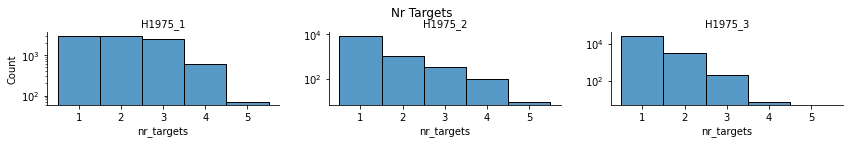

In [23]:
bins = np.array(range(1,data_count["nr_targets"].max()+1))

g = sns.displot(data_count, x="nr_targets", col="Sample", bins=bins, 
                height=2, aspect=2, facet_kws={'sharey': False})
g.fig.subplots_adjust(top=0.8)
_ = g.fig.suptitle("Nr Targets")
g.set(yscale="log", xticks = bins[:-1] + 0.5, xticklabels=bins[:-1])
g.set_titles("{col_name}")

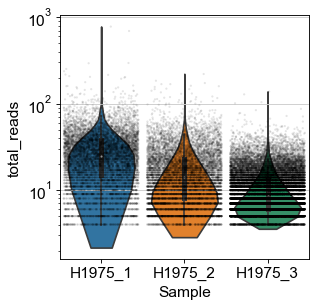

In [414]:
ax = sns.violinplot(data=data_count, y="total_reads", x="Sample", scale="width", cut=0.5)
ax = sns.stripplot(data=data_count, y="total_reads", x="Sample", size=2, jitter=0.45, color="black", alpha=0.1)
#ax.set_ylim(0,200)
ax.set_yscale("log")



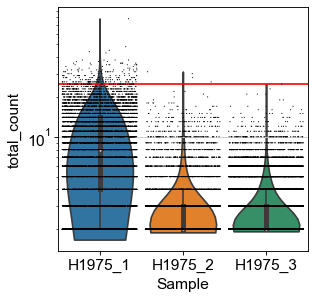

In [415]:
ax = sns.violinplot(data=data_count, y="total_count", x="Sample", bw=0.5, scale="width", cut=0.1)
ax = sns.stripplot(data=data_count, y="total_count", x="Sample", size=1, jitter=0.45, color="black")

ax.set_yscale("log")
ax.axhline(25, color="r")
#ax.set_ylim(0,20)

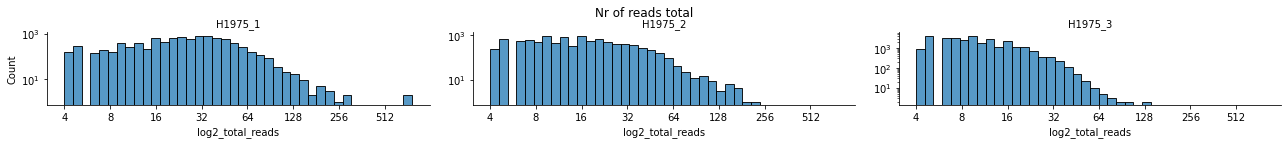

In [26]:
import matplotlib.ticker as tkr
d = data_count.copy()
d["log2_total_reads"] = np.log2(d["total_reads"])
g = sns.displot(d, x="log2_total_reads", col="Sample", col_wrap=3, bins=40,
                height=2, aspect=3, facet_kws={'sharey': False})
g.fig.subplots_adjust(top=0.8)
_ = g.fig.suptitle("Nr of reads total")
g.set(yscale="log", )
g.set_titles("{col_name}")
for ax in g.axes.flat:
    ax.xaxis.set_major_formatter(tkr.FuncFormatter(lambda x, p: str(int(2**x))))

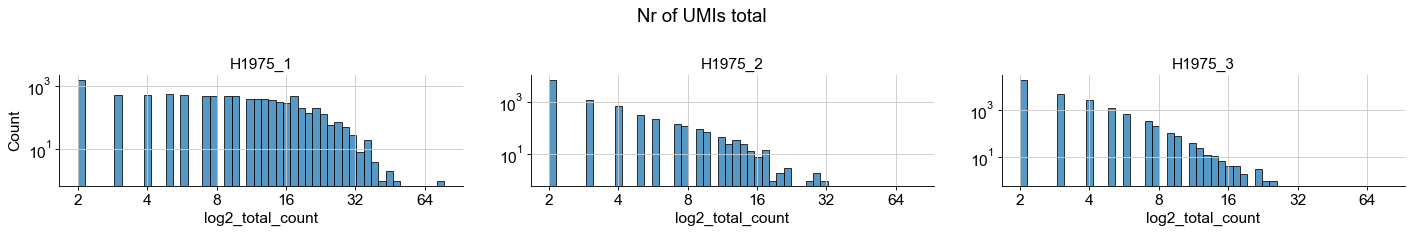

In [426]:
d = data_count.copy()
d["log2_total_count"] = np.log2(d["total_count"])
g = sns.displot(d, x="log2_total_count", col="Sample", col_wrap=3, bins=50,
                height=3, aspect=2, facet_kws={'sharey': False})
g.fig.subplots_adjust(top=0.7)
_ = g.fig.suptitle("Nr of UMIs total")
g.set(yscale="log")
g.set_titles("{col_name}")
for ax in g.axes.flat:
    ax.xaxis.set_major_formatter(tkr.FuncFormatter(lambda x, p: str(int(2**x))))
    s_mean = s_data["total_count"].mean()

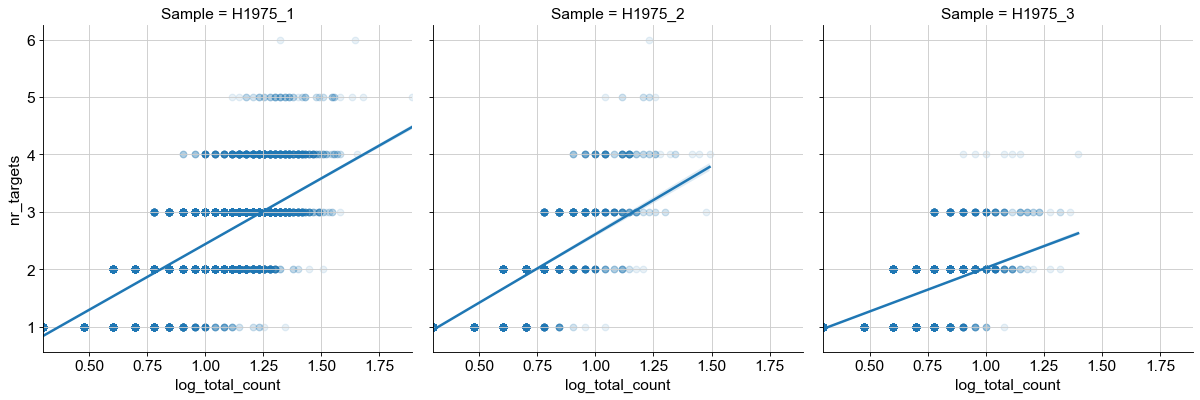

In [492]:
d = data_count.copy()
d["log_total_count"] = np.log10(d["total_count"])
sns.lmplot(data=d, x="log_total_count", y="nr_targets", col="Sample", scatter_kws={"alpha":0.1})

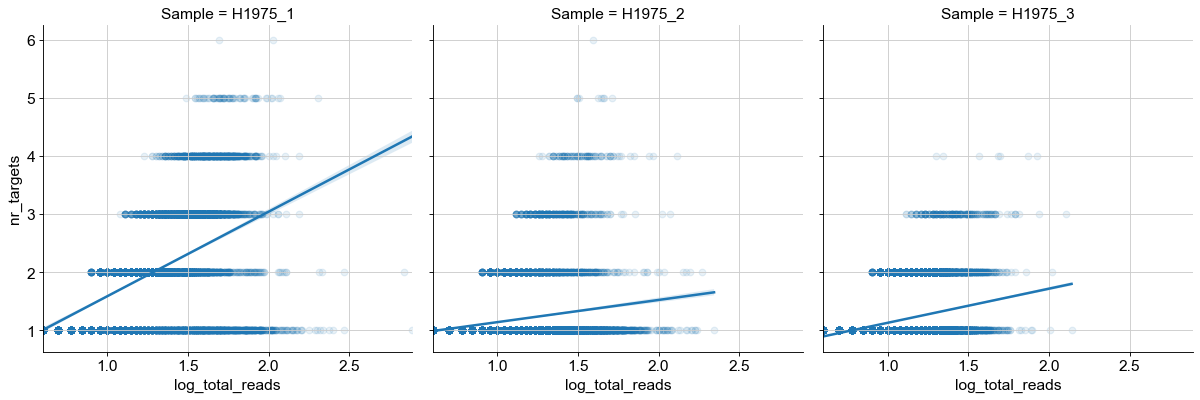

In [488]:
d = data_count.copy()
d["log_total_reads"] = np.log10(d["total_reads"])
sns.lmplot(data=d, x="log_total_reads", y="nr_targets", col="Sample", scatter_kws={"alpha":0.1})

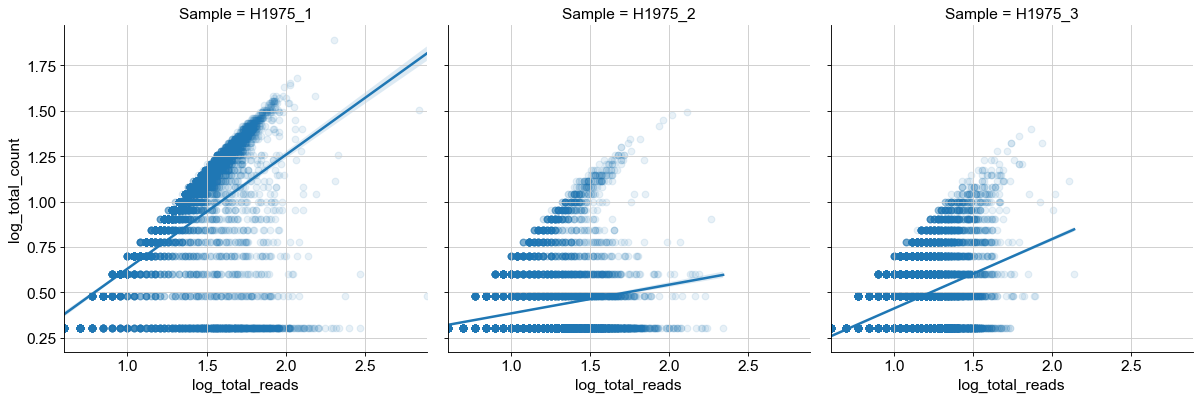

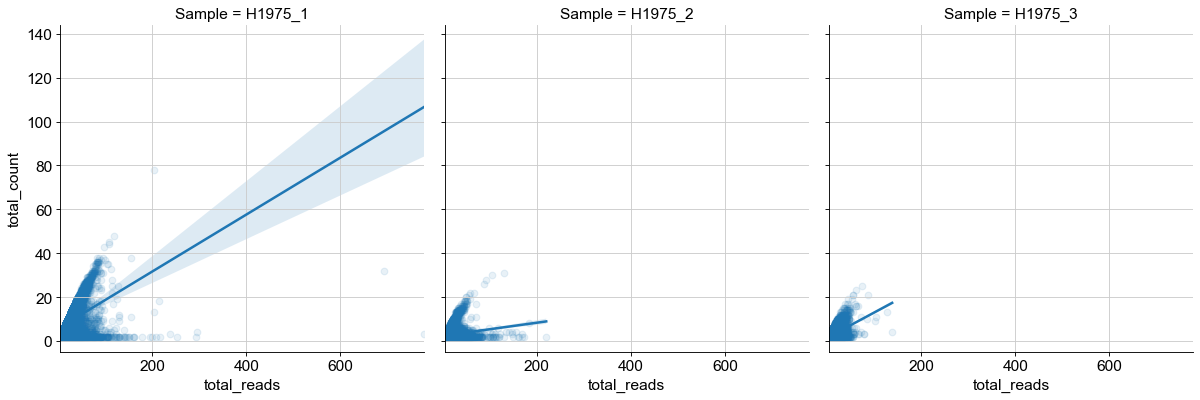

In [494]:
d = data_count.copy()
d["log_total_reads"] = np.log10(d["total_reads"])
d["log_total_count"] = np.log10(d["total_count"])
sns.lmplot(data=d, x="log_total_reads", y="log_total_count", col="Sample", scatter_kws={"alpha":0.1})
plt.show()
sns.lmplot(data=d, x="total_reads", y="total_count", col="Sample", scatter_kws={"alpha":0.1})

## Filter data further

In [5]:
data_filt = data_count.groupby("Sample", as_index=False)\
    .apply(lambda x: x[(x["total_count"]>1) & (x["total_count"] < 25)])

In [6]:
data_filt.groupby("Sample").count()["total_count"]

Sample
H1975_1     8943
H1975_2    10054
H1975_3    30350
Name: total_count, dtype: int64

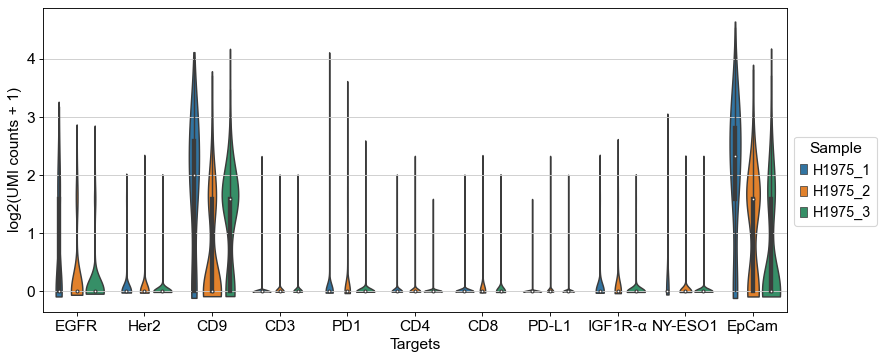

In [520]:
d=data_filt.melt(id_vars="Sample", value_vars=targets).copy()
d["value"] = np.log2(d["value"] + 1)
fig, ax = plt.subplots(figsize=(15,5))
ax = sns.violinplot(ax=ax, data=d, x="Target", y="value", hue="Sample", 
                    scale="area", bw=0.5, cut=0.2, linewidth=1.3, inner="box") 
_ = ax.set_ylabel("log2(UMI counts + 1)")
_ = ax.set_xlabel("Targets")
fig.subplots_adjust(right=0.8)
_ = plt.legend(bbox_to_anchor=(1, 0.6), title="Sample", loc='upper left')

for ext in ["png", "svg"]:
    plt.savefig(f"../figures/{today()}_H1975_violinplots.{ext}", dpi=300)


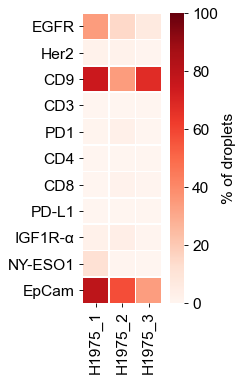

In [500]:
d = data_filt.copy()
d.loc[:,targets] = d.loc[:,targets].clip(upper=1)
d = d.loc[:,targets+ ["Sample"]]
fig, ax = plt.subplots(figsize=(3,5))
sns.heatmap(data=d.groupby("Sample").apply(lambda x: 100 * x.sum() / x.count()).T, ax=ax,
           square=True, vmin=0, vmax=100, #annot=True, fmt='.0f',
           linewidths=.5, cmap="Reds", cbar_kws={"label":"% of droplets"})
_ = plt.ylabel("")
_ = plt.xlabel("")
plt.tight_layout()

for ext in ["png", "svg"]:
    plt.savefig(f"../figures/{today()}_H1975_heatmap_targets.{ext}", dpi=300)

In [279]:
d = data_filt.copy()
d.loc[:,targets] = d.loc[:,targets].clip(upper=1)
d = d.loc[:,targets+ ["Sample"]]
d= d.groupby("Sample").apply(lambda x: round(100 * x.sum() / x.count(), 3))
d.T

Sample,H1975_1,H1975_2,H1975_3
EGFR,34.440,14.949,7.012
Her2,1.990,2.278,0.560
CD9,74.885,34.414,67.631
CD3,0.045,0.278,0.250
PD1,0.895,3.103,0.306
CD4,0.235,0.209,0.079
CD8,0.145,1.671,0.633
PD-L1,0.022,0.169,0.053
IGF1R-α,2.684,4.247,0.554
NY-ESO1,12.088,0.617,0.264


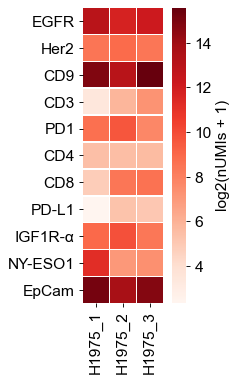

In [501]:
d = data_filt.copy()
d = d.loc[:,targets+ ["Sample"]]
fig, ax = plt.subplots(figsize=(3,5))
sns.heatmap(data=d.groupby("Sample").apply(lambda x: np.log2(x.sum()+1)).T, ax=ax,
           square=True, #annot=True, fmt='.0f', vmin=0,
           linewidths=.5, cmap="Reds", cbar_kws={"label":"log2(nUMIs + 1)"})
_ = plt.ylabel("")
_ = plt.xlabel("")
plt.tight_layout()

for ext in ["png", "svg"]:
    plt.savefig(f"../figures/{today()}_H1975_heatmap_targets_sum.{ext}", dpi=300)


In [272]:
d = data_filt.copy()
d = d.loc[:,targets + ["Sample"]]
d = d.groupby("Sample").sum().astype(int)
d["Total UMIs"] = d.sum(axis=1)
d.T

Sample,H1975_1,H1975_2,H1975_3
EGFR,8290,3450,4613
Her2,366,492,345
CD9,30468,8561,48996
CD3,10,57,154
PD1,424,803,212
CD4,43,45,48
CD8,28,351,387
PD-L1,4,38,33
IGF1R-α,503,915,344
NY-ESO1,2465,131,165


## Combinations analysis

In [309]:
data_filt[data_filt["nr_targets"] > 1].groupby("Sample").count()["CD3"]

Sample
H1975_1    5999
H1975_2    1434
H1975_3    3240
Name: CD3, dtype: int64

In [304]:
d = data_filt[data_filt["nr_targets"] > 1].copy()
#d = data_filt.copy()
combos=[]
for i in range(2,5):
    for ts in combinations(targets, i):
        if i == 1:
            combo = f"{ts[0]}"
        else:
            combo = " & ".join(ts)
        combos.append(combo)
        ts_list = list(ts)
        t = ts_list.pop()
        temp = (d[t] > 0)
        while ts_list:
            t = ts_list.pop()
            temp = np.logical_and(temp, (d[t] > 0))
            if temp.all():
                break
        
        d[combo] = temp.astype(int) 

d = d.loc[:,combos+ ["Sample"]]
#d = d.groupby("Sample").apply(lambda x: x.sum())
#d.drop("Sample", axis=1, inplace=True)
d = d.groupby("Sample").apply(lambda x: 100 * x.sum() / x.count())

#d = d.sort_values(by="H1975_1", axis=1, ascending=False)
maxd = d.mean()#agg(lambda x: x.std()/x.mean()).copy()
maxd.name = "max"
d = d.append(maxd)
d = d.sort_values(by="max", axis=1, ascending=False)
d.drop("max", inplace=True)

/Users/pontus.hojer/miniconda3/envs/dbspro/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  # Remove the CWD from sys.path while we load stuff.


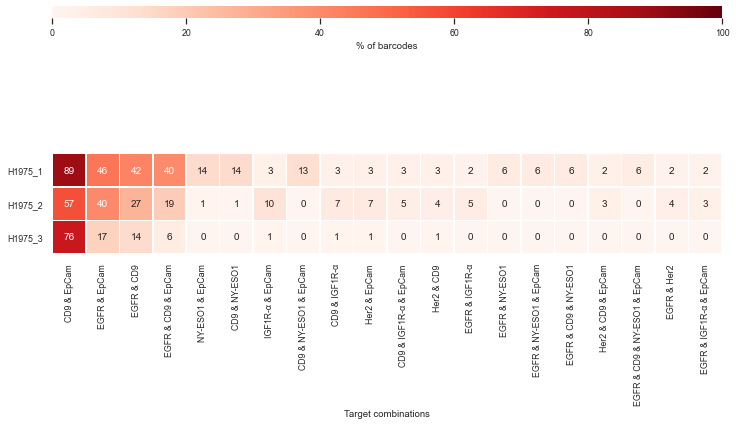

In [307]:

grid_kws = {"height_ratios": (.03, .9), "hspace": .01}
f, (cbar_ax, ax) = plt.subplots(2, gridspec_kw=grid_kws, figsize=(12,7))
ax = sns.heatmap(data=d.iloc[:,:20], ax=ax, cbar_ax=cbar_ax, 
                 cbar_kws={"orientation": "horizontal", "label":"% of barcodes"},
                 square=True, vmin=0, vmax=100, annot=True, fmt='.0f',
                 linewidths=.5, cmap="Reds", xticklabels=1,
                 annot_kws={"fontsize":10})
_ = plt.xlabel("Target combinations")
_ = plt.ylabel("")
plt.tight_layout()
for ext in ["png", "svg"]:
    plt.savefig(f"../figures/{today()}.H1975.heatmap_top20_combos.{ext}", dpi=300)

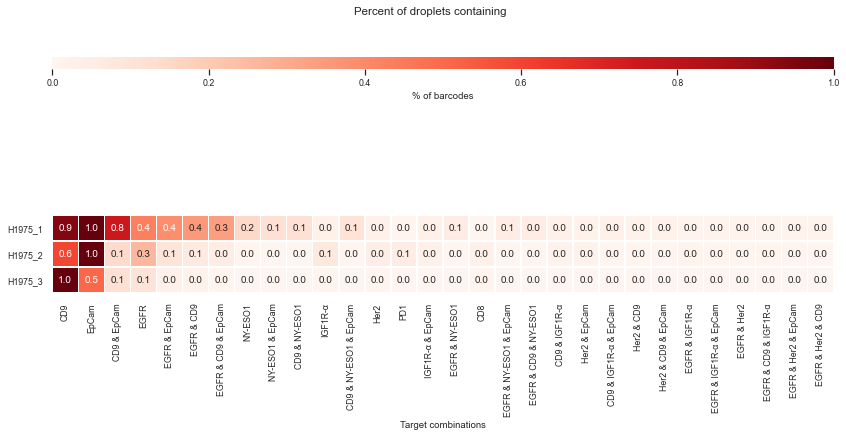

In [223]:
grid_kws = {"height_ratios": (.03, .9), "hspace": .01}
f, (cbar_ax, ax) = plt.subplots(2, gridspec_kw=grid_kws, figsize=(14,7))
f.suptitle("Percent of droplets containing")
ax = sns.heatmap(data=d.div(d.max(axis=1), axis=0).iloc[:3,:30], ax=ax, cbar_ax=cbar_ax, 
                 cbar_kws={"orientation": "horizontal", "label":"% of barcodes"},
                 square=True, vmin=0, annot=True, fmt='.1f',
                 linewidths=.5, cmap="Reds", xticklabels=1,
                 annot_kws={"fontsize":10})
_ = plt.xlabel("Target combinations")
_ = plt.ylabel("")

#for ext in ["png", "svg"]:
#    plt.savefig(f"../figures/{today()}.Patients.heatmap_top30_combos.{ext}", dpi=300)

In [244]:
d = data_filt[data_filt["nr_targets"] > 1].copy()
combos=[]
for i in range(2,4):
    for ts in combinations(targets, i):
        if i == 1:
            combo = f"Only {ts[0]}"
        else:
            combo = " & ".join(ts)
        combos.append(combo)
        ts_list = list(ts)
        temp = None
        for t in ts_list:
            if temp is None:
                temp = (d[t] > 0)
            else:
                temp = np.logical_and(temp, (d[t] > 0))
            if temp.all():
                break
        not_ts = [t for t in targets if t not in ts]
        temp = np.logical_and(temp, (d.loc[:, not_ts] == 0).all(axis=1) )
        d[combo] = temp.astype(int)
d = d.loc[:,combos+ ["Sample"]]
d = d.groupby("Sample").apply(lambda x: 100* x.sum() / x.count())
d = d.loc[:, (d != 0).any(axis=0)]
#d = d.groupby("Sample").apply(lambda x: x.sum())
maxd = d.mean()#agg(lambda x: x.std()/x.mean()).copy()
maxd.name = "max"
d = d.append(maxd)

d = d.sort_values(by="max", axis=1, ascending=False) 

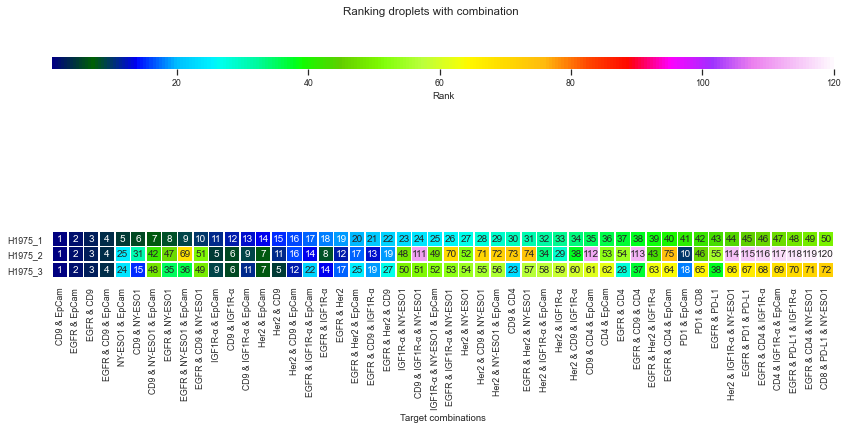

In [255]:
grid_kws = {"height_ratios": (.03, .9), "hspace": .01}
f, (cbar_ax, ax) = plt.subplots(2, gridspec_kw=grid_kws, figsize=(14,7))
f.suptitle("Ranking droplets with combination")
ax = sns.heatmap(data=d.sort_values(by="H1975_1", axis=1, ascending=False).rank(1, method="first", ascending=False).iloc[:,:50], ax=ax, cbar_ax=cbar_ax, 
                 cbar_kws={"orientation": "horizontal", "label":"Rank"},
                 square=True, annot=True, fmt='.0f',
                 linewidths=.5, cmap="gist_ncar", xticklabels=1,
                 annot_kws={"fontsize":10})
_ = plt.xlabel("Target combinations")
_ = plt.ylabel("")

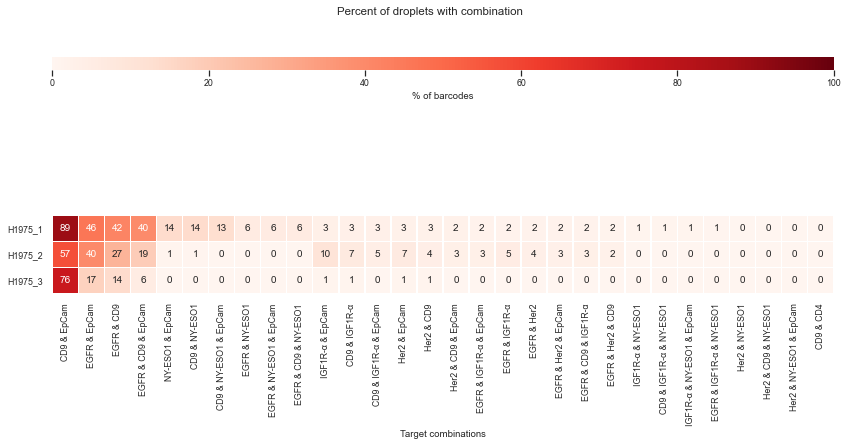

In [257]:
grid_kws = {"height_ratios": (.03, .9), "hspace": .01}
f, (cbar_ax, ax) = plt.subplots(2, gridspec_kw=grid_kws, figsize=(14,7))
f.suptitle("Percent of droplets with combination")
ax = sns.heatmap(data=d.sort_values(by="H1975_1", axis=1, ascending=False).iloc[:3,:30], ax=ax, cbar_ax=cbar_ax, 
                 cbar_kws={"orientation": "horizontal", "label":"% of barcodes"},
                 square=True, vmin=0, vmax=100, annot=True, fmt='.0f',
                 linewidths=.5, cmap="Reds", xticklabels=1,
                 annot_kws={"fontsize":10})
_ = plt.xlabel("Target combinations")
_ = plt.ylabel("")

/Users/pontus.hojer/miniconda3/envs/dbspro/lib/python3.6/site-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in log2
  This is separate from the ipykernel package so we can avoid doing imports until


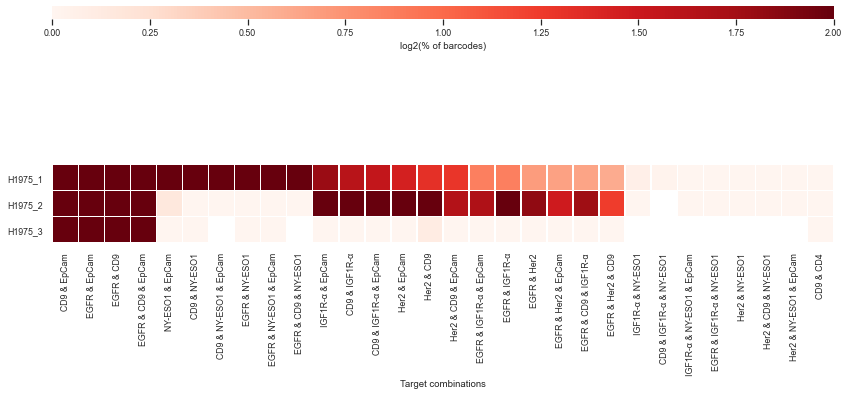

In [260]:
grid_kws = {"height_ratios": (.03, .9), "hspace": .01}
f, (cbar_ax, ax) = plt.subplots(2, gridspec_kw=grid_kws, figsize=(14,7))
ax = sns.heatmap(data=np.log2(d.sort_values(by="H1975_1", axis=1, ascending=False).iloc[:3,:30]), ax=ax, cbar_ax=cbar_ax, 
                 cbar_kws={"orientation": "horizontal", "label":"log2(% of barcodes)"},
                 square=True, vmin=0, vmax=2, #annot=True, fmt='.0f',
                 linewidths=.5, cmap="Reds", xticklabels=1,
                 annot_kws={"fontsize":10})
_ = plt.xlabel("Target combinations")
_ = plt.ylabel("")

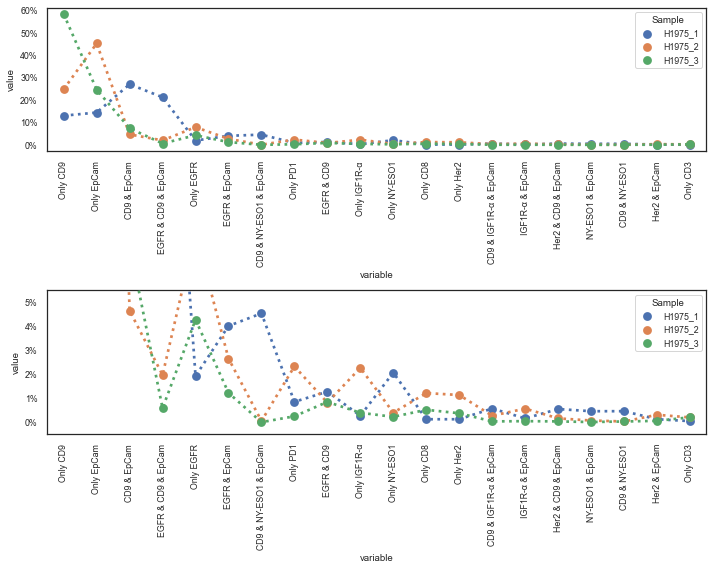

In [169]:
import matplotlib.ticker as mtick
f, (ax1, ax2) = plt.subplots(nrows=2, figsize=(10,8))
ax1 = sns.pointplot(data=d.iloc[:3,:20].melt(ignore_index=False).reset_index(), 
                    x="variable", y="value", hue="Sample", ax=ax1, 
                    linestyles=":", alpha=0.7)
ax1.set_xticklabels(ax1.get_xticklabels(), rotation=90) 
ax1.yaxis.set_major_formatter(mtick.PercentFormatter())
ax2 = sns.pointplot(data=d.iloc[:3,:20].melt(ignore_index=False).reset_index(), 
                    x="variable", y="value", hue="Sample", ax=ax2, 
                    linestyles=":", alpha=0.7)
ax2.yaxis.set_major_formatter(mtick.PercentFormatter(decimals=0))
_ = ax2.set_ylim(-0.5,5.5)
ax2.set_xticklabels(ax2.get_xticklabels(), rotation=90) 

plt.tight_layout()
plt.show()

#for ext in ["png", "svg"]:
#    plt.savefig(f"../figures/{today()}.Patients.heatmap_top30_combos.{ext}", dpi=300)

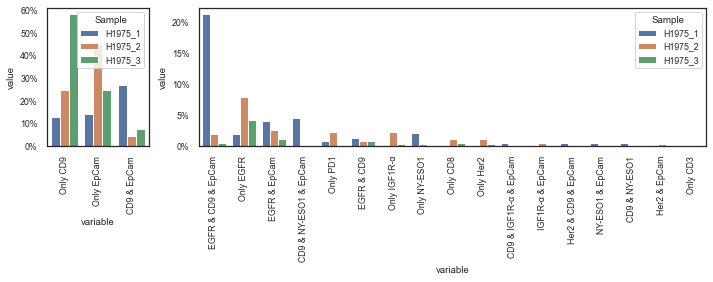

In [170]:
f, (ax1, ax2) = plt.subplots(ncols=2, figsize=(10,4), gridspec_kw={'width_ratios': [1, 5]})
ax = sns.barplot(data=d.iloc[:3,:3].melt(ignore_index=False).reset_index(), 
                 x="variable", y="value", hue="Sample", ax=ax1)
ax1.set_xticklabels(ax1.get_xticklabels(), rotation=90) 
ax1.yaxis.set_major_formatter(mtick.PercentFormatter())
ax2 = sns.barplot(data=d.iloc[:3,3:20].melt(ignore_index=False).reset_index(), 
                  x="variable", y="value", hue="Sample", ax=ax2)
#_ = ax2.set_ylim(0,10.5)
ax2.yaxis.set_major_formatter(mtick.PercentFormatter(decimals=0))
ax2.set_xticklabels(ax2.get_xticklabels(), rotation=90) 

plt.tight_layout()
plt.show()
#for ext in ["png", "svg"]:
#    plt.savefig(f"../figures/{today()}.Patients.heatmap_top30_combos.{ext}", dpi=300)

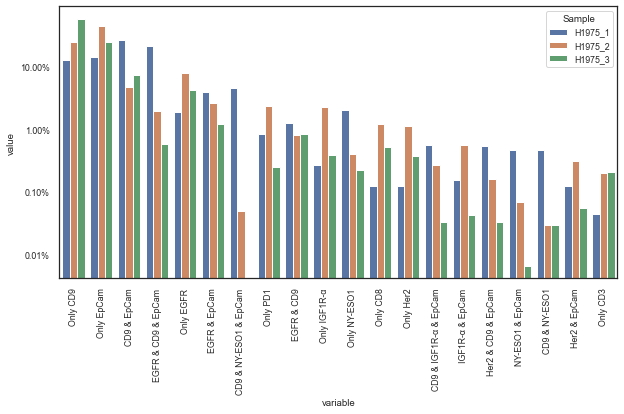

In [171]:
fig, ax = plt.subplots(figsize=(10,5))
ax = sns.barplot(data=d.iloc[:3,:20].melt(ignore_index=False).reset_index(), 
            x="variable", y="value", hue="Sample", ax=ax)
ax.set_yscale("log")
ax.yaxis.set_major_formatter(mtick.PercentFormatter(decimals=2))
_ =  ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
plt.show()

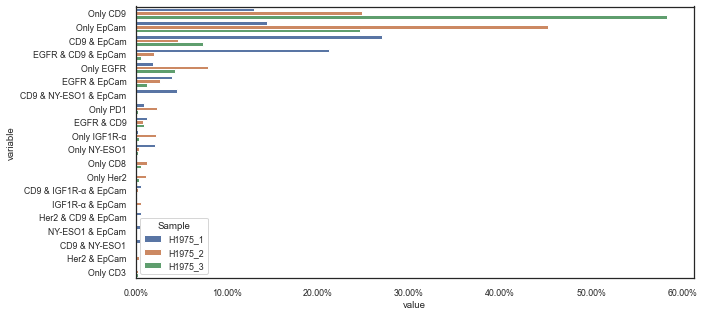

In [172]:
fig, ax = plt.subplots(figsize=(10,5))
ax = sns.barplot(data=d.iloc[:3,:20].melt(ignore_index=False).reset_index(), 
            y="variable", x="value", hue="Sample", ax=ax)
#ax.set_xscale("log")
ax.xaxis.set_major_formatter(mtick.PercentFormatter(decimals=2))
#_ =  ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
plt.show()

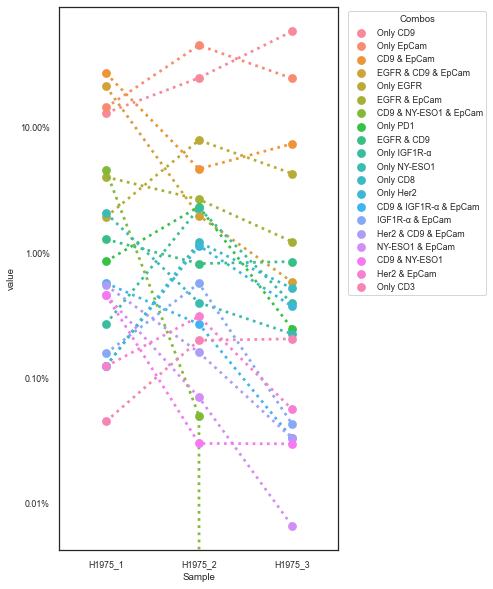

In [175]:
fig, ax = plt.subplots(figsize=(5,10))
ax = sns.pointplot(data=d.iloc[:3,:20].melt(ignore_index=False).reset_index(),
              x="Sample", y="value", hue="variable", dodge=False, linestyles=":", ax=ax)
ax.set_yscale("log")
ax.yaxis.set_major_formatter(mtick.PercentFormatter(decimals=2))
_ = plt.legend(bbox_to_anchor=(1.02, 1), title="Combos", loc='upper left')

## Alignment score

In [502]:
from sklearn.neighbors import KNeighborsClassifier

def alignment_score(X, y, k_part=0.01):
    # Alignment Score 0=bad, 1=perfect
    # Part of early seurat package.
    # Bulter et al. 2018. https://www.nature.com/articles/nbt.4096

    k = int(k_part*X.shape[0])
    n = len(np.unique(y))
    #print(f"Using k_part = {k_part}, n_neighbors={k}")

    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X, y)

    x_batch = np.zeros(X.shape[0])
    for i in range(X.shape[0]):
        label = y[i]
        sample = X[i, :].reshape(1, -1)
        neighbours = knn.kneighbors(sample, return_distance=False)[0]
        neighbours_samples = y[neighbours]
        unique, counts = np.unique(neighbours_samples, return_counts=True)
        unique_counts = dict(zip(unique, counts))
        x_batch[i] = unique_counts.get(label, 0) 
    
    d = k/n
    return 1 - (np.mean(x_batch) - d) / (k - d)

# Validation comparing aginst self should return 1
sampleA = data_filt[data_filt["Sample"]=="H1975_1"].copy()
sampleA["Sample"] += "A"
sampleB = data_filt[data_filt["Sample"]=="H1975_1"].copy()
sampleB["Sample"] += "B"

tmp_samples = pd.concat([sampleA, sampleB])
alignment_score(tmp_samples.loc[:, targets].values, tmp_samples["Sample"].values, 0.02)

1.0

In [335]:
scores = np.zeros((3,3))
min_cell_count = 1000
for s in combinations(samples, 2):
    i = np.where(np.array(samples) == s[0])
    j = np.where(np.array(samples) == s[1])
    d = data_filt[data_filt["Sample"].isin(s)].copy()

    # Repeat measurements
    ss = np.zeros(10) 
    for k in range(len(ss)):
        p = d.groupby("Sample", as_index=False).sample(min_cell_count)
        ss[k] = alignment_score(p.loc[:,targets].to_numpy(),p["Sample"].values, k_part=0.01)
    
    print(ss, ss.std()/ss.mean())
    scores[j, i] = ss.mean()
    
scores = pd.DataFrame(data=scores, columns=samples, index=samples)
scores

[0.59245 0.57395 0.52245 0.7107  0.68345 0.54325 0.67295 0.68145 0.6999
 0.679  ] 0.10482133339963152
[0.7664  0.6869  0.5082  0.82005 0.7397  0.74175 0.7484  0.83945 0.75855
 0.7915 ] 0.11827024097265254
[0.8054  0.78835 0.9237  0.8455  0.7639  0.90605 0.8755  0.8666  0.77845
 0.77315] 0.06658729798079276


,H1975_1,H1975_2,H1975_3
H1975_1,0.000000,0.00000,0.0
H1975_2,0.635955,0.00000,0.0
H1975_3,0.740090,0.83266,0.0


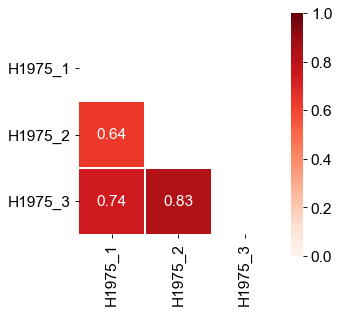

In [341]:
mask = np.zeros_like(scores)
mask[np.triu_indices_from(mask)] = True
ax = sns.heatmap(scores, vmax=1, vmin=0, center=0.5, cmap="Reds", square=True, mask=mask, 
                 annot=True, fmt=".2f", xticklabels=1, linewidths=.5,)
_ = plt.yticks(rotation=0) 
_ = plt.xticks(rotation=90) 

## Scanpy

In [362]:
import scanpy as sc
sc.settings.verbosity = 2             # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.logging.print_header()
sc.settings.set_figure_params(dpi=80, facecolor='white')
sc.settings.figdir = "../figures"

scanpy==1.7.2 anndata==0.7.6 umap==0.5.1 numpy==1.19.2 scipy==1.5.2 pandas==1.1.5 scikit-learn==0.24.1 statsmodels==0.12.2 python-igraph==0.9.1 louvain==0.7.0


In [453]:
d = data_filt.copy()
X = d.loc[:,targets].values
obs = d.loc[:, ["total_count", "total_reads", "nr_targets", "Sample"]].reset_index()
var = pd.DataFrame(index=targets)
adata = sc.AnnData(X, obs, var)

/Users/pontus.hojer/miniconda3/envs/dbspro/lib/python3.6/site-packages/anndata/_core/anndata.py:120: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


In [435]:
adata

AnnData object with n_obs × n_vars = 49347 × 11
    obs: 'level_0', 'Barcode', 'total_count', 'total_reads', 'nr_targets', 'Sample'

normalizing counts per cell
    finished (0:00:00)


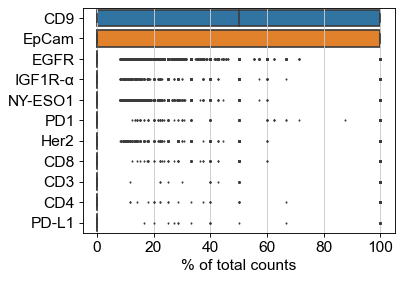

In [437]:
sc.pl.highest_expr_genes(adata, n_top=11, )

... storing 'Sample' as categorical


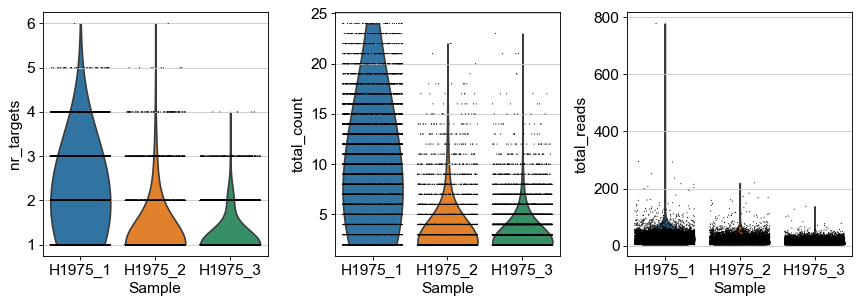

In [438]:
sc.pl.violin(adata, ['nr_targets', 'total_count', "total_reads"],
             jitter=0.4, multi_panel=True, bw=1, groupby="Sample")

In [439]:
target_counts = adata.var.copy()
target_counts["count"] = (adata.X != 0).sum(axis=0)

target_counts

,count
EGFR,6711
Her2,577
CD9,30683
CD3,108
PD1,485
CD4,66
CD8,373
PD-L1,35
IGF1R-α,835
NY-ESO1,1223


In [454]:
# Filter
sc.pp.filter_cells(adata, min_genes=3)
#sc.pp.filter_genes(adata, min_cells=200)


filtered out 45715 cells that have less than 3 genes expressed


In [506]:
# Calculate nr of remaining barcodes for each sample
adata.obs.groupby("Sample").count()["Barcode"]

Sample
H1975_1    2984
H1975_2     427
H1975_3     221
Name: Barcode, dtype: int64

... storing 'Sample' as categorical


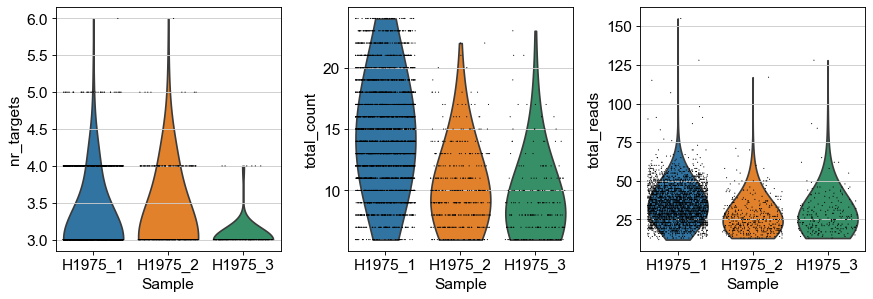

In [456]:
sc.pl.violin(adata, ['nr_targets', 'total_count', "total_reads"],
             jitter=0.4, multi_panel=True, bw=1, groupby="Sample")

In [262]:
def clr_normalize_adata(adata, on_cells=False, inplace=True):
    """Normalize count vector for each cell, i.e. for each row of .X"""
    def seurat_clr(x):
        s = np.sum(np.log1p(x[x > 0]))
        exp = np.exp(s / len(x))
        return np.log1p(x / exp)
   
    if not inplace:
        adata = adata.copy()

    # apply to dense or sparse matrix, along axis. returns dense matrix
    if on_cells:
        adata.X = np.apply_along_axis(seurat_clr, 1, adata.X)
    else:
        x = np.array(adata.X)
        adata.X = np.log1p(np.divide(x, gmean(x[x>0], axis=0)))
    return adata

In [507]:
# Normalize data
adata.raw = adata
for s in samples:
    #clr_normalize(adata[adata.obs.Sample == s, :], on_cell=False, inplace=True)
    clr_normalize_adata(adata[adata.obs.Sample == s, :], on_cells=False, inplace=True)

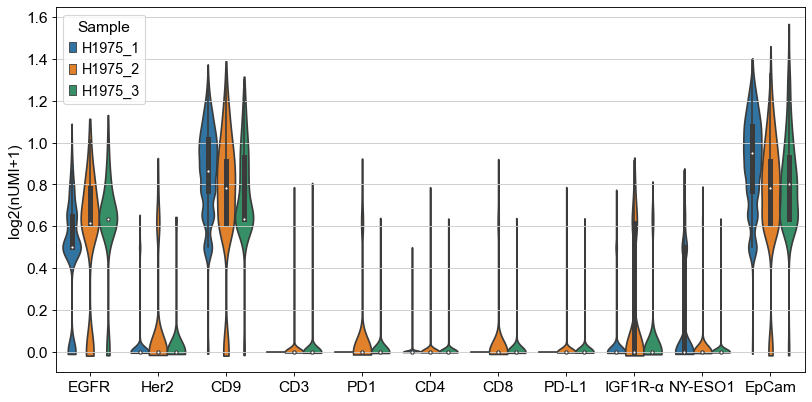

In [514]:
plotdf = pd.DataFrame(data=np.log2(adata.raw.X + 1), columns=adata.var.index)
plotdf["Sample"] = adata.obs["Sample"].values

plotdf.melt(id_vars="Sample")
fig, ax = plt.subplots(figsize=(12,6))
ax = sns.violinplot(data=plotdf.melt(id_vars="Sample"), x="variable", y="value", hue="Sample", 
                    ax=ax, cut=0.2, scale="width")
_ = ax.set_ylabel("log2(nUMI+1)")
_ = ax.set_xlabel("")

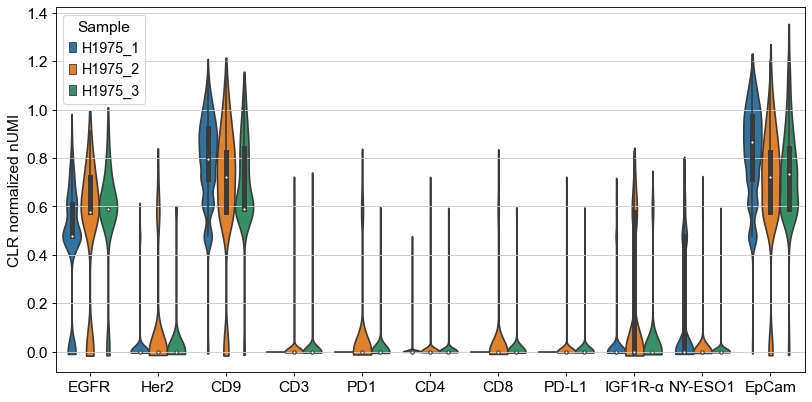

In [513]:
plotdf = pd.DataFrame(data=adata.X, columns=adata.var.index)
plotdf["Sample"] = adata.obs["Sample"].values

plotdf.melt(id_vars="Sample")
fig, ax = plt.subplots(figsize=(12,6))
ax = sns.violinplot(data=plotdf.melt(id_vars="Sample"), x="variable", y="value", hue="Sample", 
                    ax=ax, cut=0.2, scale="width")
_ = ax.set_ylabel("CLR normalized nUMI")
_ = ax.set_xlabel("")

### PCA analysis

In [461]:
sc.tl.pca(adata, svd_solver='arpack')

computing PCA
    with n_comps=10
    finished (0:00:00)


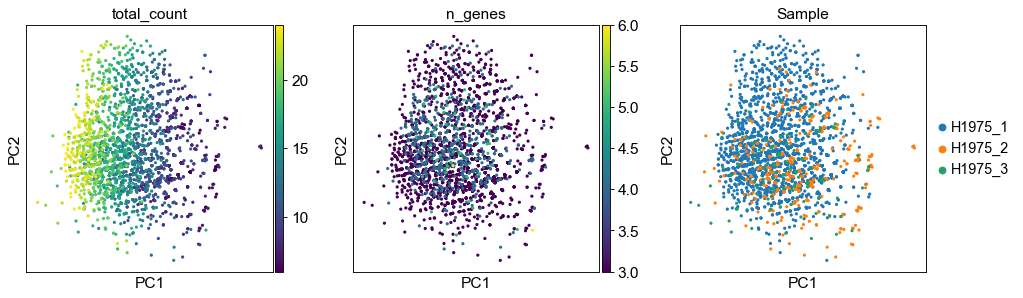

In [462]:
sc.pl.pca(adata, color=['total_count', "n_genes", 'Sample'], use_raw=False)

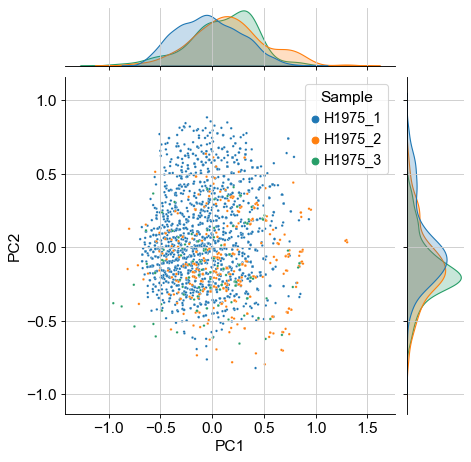

In [515]:
plotdf = sc.get.obs_df(adata, keys=["Sample"], obsm_keys=[("X_pca",0),("X_pca",1)])
plotdf.columns = ['Sample', 'PC1', 'PC2']
g = sns.jointplot(data=plotdf, x="PC1", y="PC2", hue="Sample", 
                  kind="scatter", s=5, marginal_kws={"common_norm": False})


for ext in ["png", "svg"]:
    plt.savefig(f"../figures/{today()}_H1975_pca_jointplot.{ext}", dpi=300)

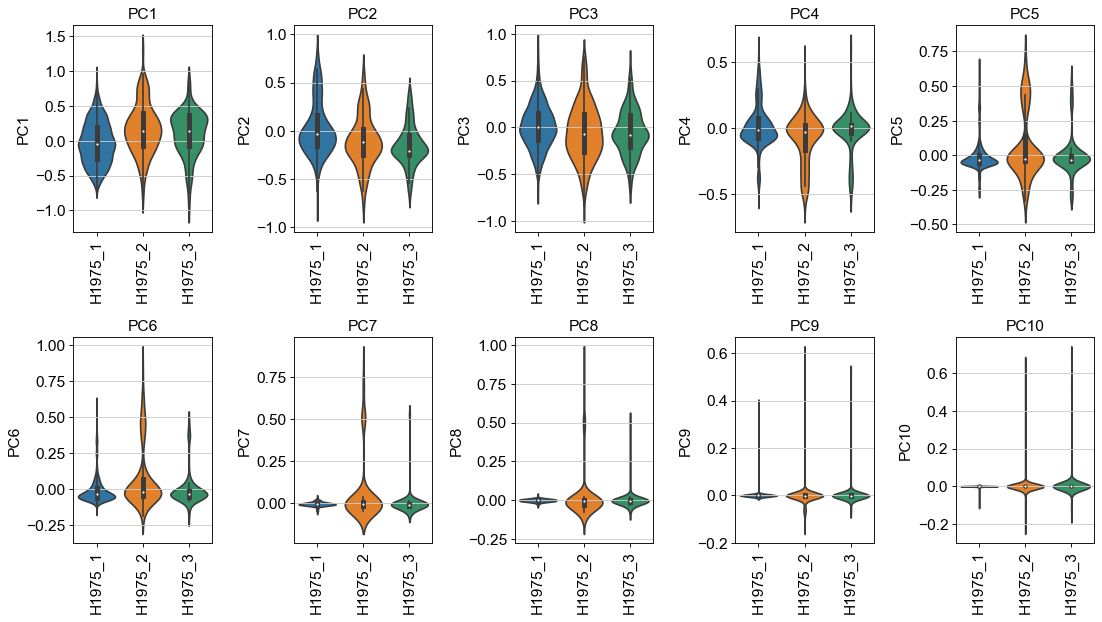

In [519]:
pcs = [f"PC{i}" for i in range(1, adata.obsm["X_pca"].shape[1]+1)]
df = pd.DataFrame(data = adata.obsm["X_pca"], columns=pcs)
df["Sample"] = adata.obs["Sample"].values

fig, axes = plt.subplots(nrows=2, ncols=len(pcs) // 2, figsize=(14,8))
for pc, ax in zip(pcs, axes.ravel()):
    ax = sns.violinplot(data=df, x="Sample", y=pc, ax=ax, scale="width")
    _ = ax.set_xlabel("")
    ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
    ax.set_title(pc)
plt.tight_layout()

for ext in ["png", "svg"]:
    plt.savefig(f"../figures/{today()}_H1975_pca_comps_violin.{ext}", dpi=300)

computing density on 'PCA'


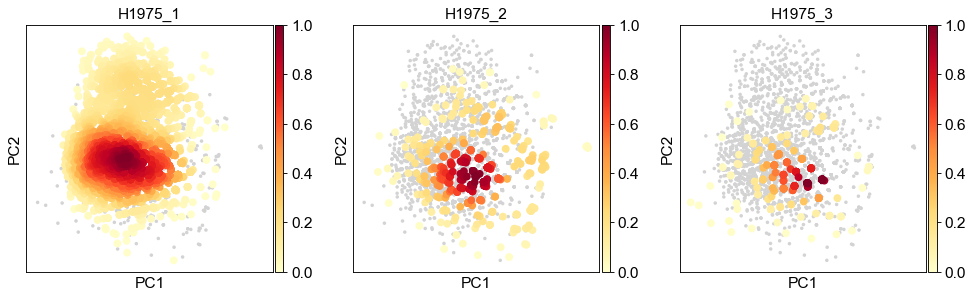

In [468]:
sc.tl.embedding_density(adata, basis="PCA", groupby="Sample")
sc.pl.embedding_density(adata, basis="PCA", key="pca_density_Sample", bg_dotsize=40, fg_dotsize=200)

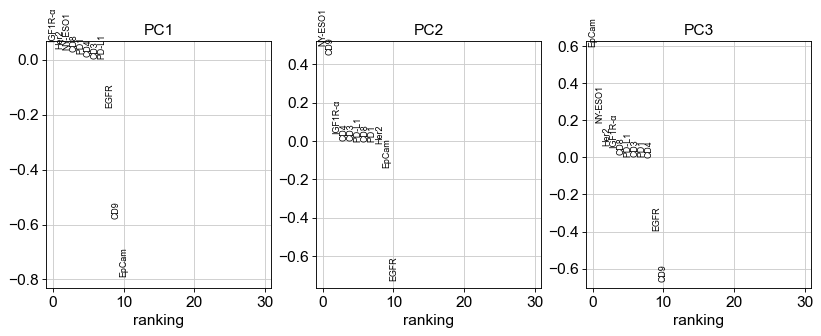

In [469]:
sc.pl.pca_loadings(adata, include_lowest=False)

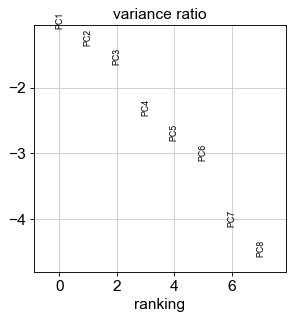

In [470]:
sc.pl.pca_variance_ratio(adata, log=True, n_pcs=7)

In [471]:
sc.pp.neighbors(adata, n_neighbors=100, n_pcs=None)

computing neighbors
    using data matrix X directly
    finished (0:00:00)


computing UMAP


0.1


    finished (0:00:13)


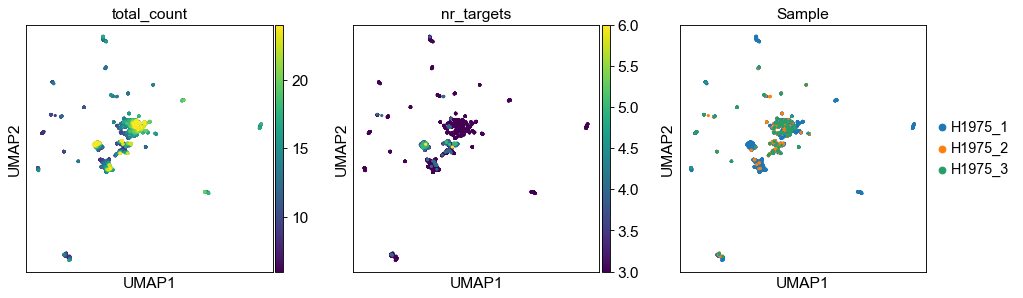

computing UMAP


0.3


    finished (0:00:13)


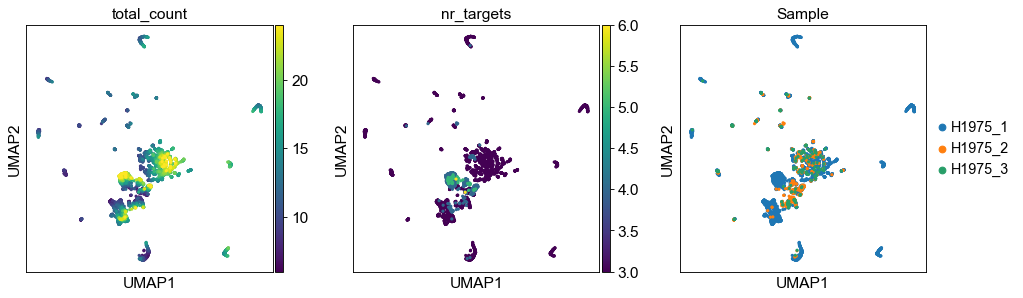

computing UMAP


0.5


    finished (0:00:14)


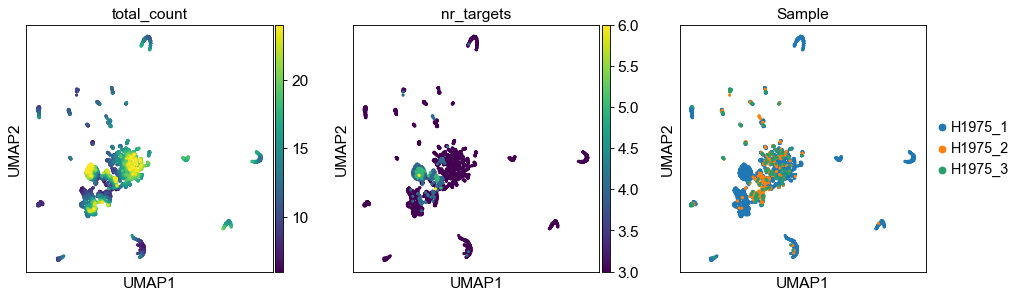

computing UMAP


0.7


    finished (0:00:13)


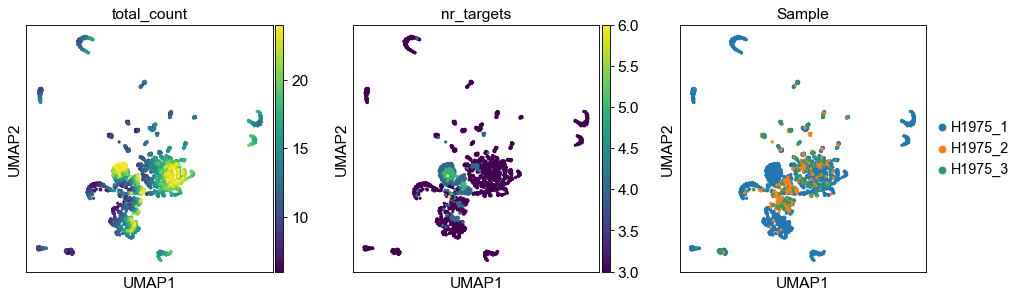

computing UMAP


0.9


    finished (0:00:13)


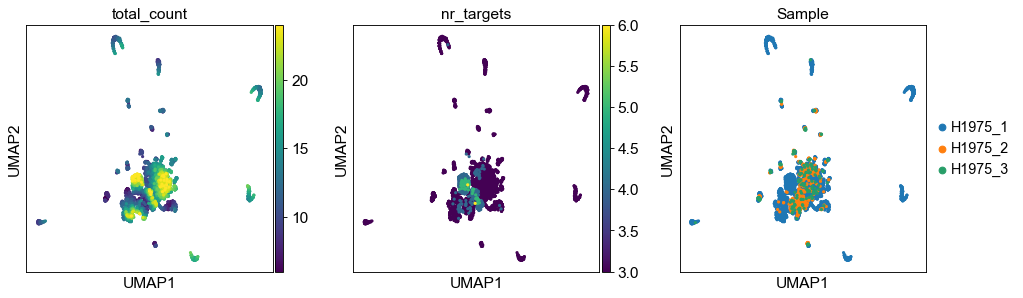

In [472]:
for dist in [0.1, 0.3, 0.5, 0.7, 0.9]:
    print(dist)
    sc.tl.umap(adata, min_dist=dist)
    sc.pl.umap(adata, color=['total_count', 'nr_targets', 'Sample'])
    plt.show()

In [179]:
sc.tl.umap(adata, min_dist=0.9)

computing UMAP
    finished (0:00:14)


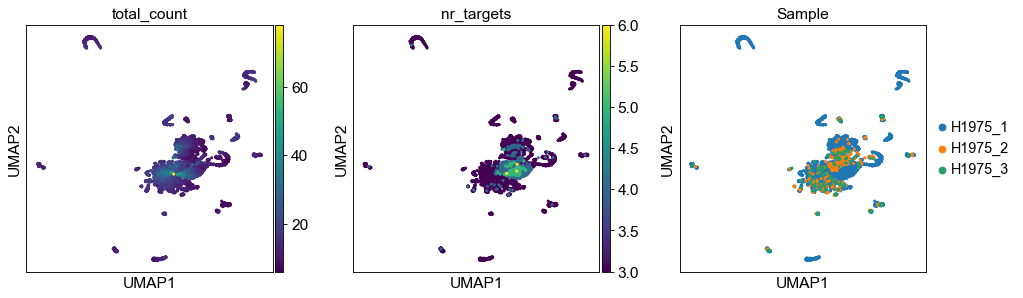

In [180]:
sc.pl.umap(adata, color=['total_count', 'nr_targets', 'Sample'])

In [473]:
sc.tl.embedding_density(adata, groupby='Sample')

computing density on 'umap'


/Users/pontus.hojer/miniconda3/envs/dbspro/lib/python3.6/site-packages/scanpy/plotting/_tools/__init__.py:1186: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = copy.copy(mpl.cm.get_cmap("YlOrRd"))
  color_map.set_over('black')
/Users/pontus.hojer/miniconda3/envs/dbspro/lib/python3.6/site-packages/scanpy/plotting/_tools/__init__.py:1187: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = copy.copy(mpl.cm.get_cmap("YlOrRd"))
  color_map.set_under('lightgray')
/Users/pontus.hojer/miniconda3/envs/dbspro/lib/python3.6/site-packages/scanpy/plotting/_tools/scatterplots.py:370: MatplotlibDeprecationW

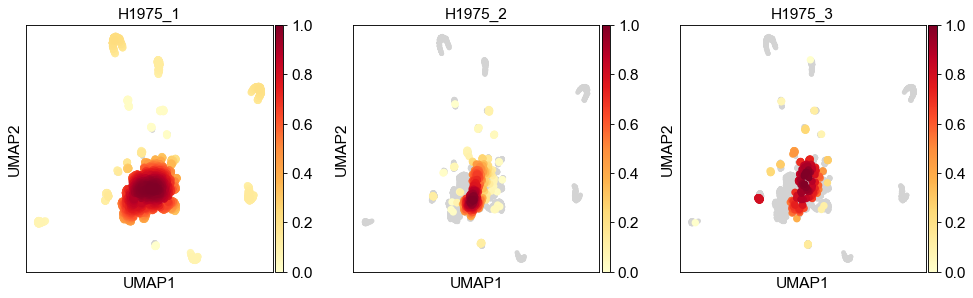

In [474]:
sc.pl.embedding_density(adata, groupby='Sample')